<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load" data-toc-modified-id="Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Datetime-features" data-toc-modified-id="Datetime-features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Datetime features</a></span></li><li><span><a href="#Click-&amp;-download-stats" data-toc-modified-id="Click-&amp;-download-stats-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Click &amp; download stats</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#One-hot-encode-categorical-features" data-toc-modified-id="One-hot-encode-categorical-features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>One-hot encode categorical features</a></span></li></ul></li><li><span><a href="#Save-data-objects" data-toc-modified-id="Save-data-objects-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save data objects</a></span></li></ul></div>

## Load

Packages

In [15]:
# Data tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

# Programming tools
import os
import sys
import gc

# Notebook options
%matplotlib inline
pd.set_options('display.max_columns', 0)

AttributeError: module 'pandas' has no attribute 'set_options'

Paths

In [2]:
from HERE import *
!cat HERE.py

import os

PYTHON_SCRIPTS_DIR = os.path.dirname(os.path.realpath(__file__))
PROJ_ROOT_DIR = os.path.abspath(os.path.join(PYTHON_SCRIPTS_DIR, os.pardir))
SCRATCH_DIR = os.path.join(PROJ_ROOT_DIR, 'scratch')


Data

In [3]:
%%time
use_train_sample = False
train = pd.read_csv('../downloads/train_sample.csv') if use_train_sample else pd.read_csv('../downloads/train.csv')
test = pd.read_csv('../downloads/test.csv')

CPU times: user 2min 22s, sys: 49.1 s, total: 3min 11s
Wall time: 3min 36s


## Feature Engineering

In [4]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (184903890, 8)
test shape: (18790469, 7)


In [5]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [6]:
display(train.info())
display(test.info())

train data size: 26.88 GB
test data size: 2.17 GB


Drop the `attributed_time` column of training data, because it is not available in test data.

In [7]:
train.drop(columns=['attributed_time'], inplace=True)

### Datetime features

In [8]:
def extend_datetime_features(df):
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['click_hour'] = df['click_time'].dt.hour
    df['click_minute'] = df['click_time'].dt.minute
    df['click_second'] = df['click_time'].dt.second
    df['click_minute_mod15'] = df['click_minute'] % 15
    df['click_second_mod5'] = df['click_second'] % 5
    return df

train = extend_datetime_features(train)
test = extend_datetime_features(test)

train.head()

,ip,app,device,os,channel,click_time,is_attributed,click_hour,click_minute,click_second,click_minute_mod15,click_second_mod5
0,83230,3,1,13,379,2017-11-06 14:32:21,0,14,32,21,2,1
1,17357,3,1,19,379,2017-11-06 14:33:34,0,14,33,34,3,4
2,35810,3,1,13,379,2017-11-06 14:34:12,0,14,34,12,4,2
3,45745,14,1,13,478,2017-11-06 14:34:52,0,14,34,52,4,2
4,161007,3,1,13,379,2017-11-06 14:35:08,0,14,35,8,5,3


### Click & download stats

Create click & download counts grouped by different features.

In [9]:
%%time
stats_by_ = {}
for ft in ['ip', 'app', 'device', 'os', 'channel']:
    # For each feature (ip, app, device, etc.) count clicks and downloads grouped by that feature
    # you'll have columns like `clicks_by_ip`, `downloads_by_ip`, `download_ratio_by_ip`, `clicks_by_app`, ...
    stats = train.groupby(ft).agg({'is_attributed': ['size', 'sum']})
    stats.columns = stats.columns.droplevel(0)
    cl_colname, dl_colname, ratio_colname = [col+'_by_'+ft for col in ['clicks', 'downloads', 'download_ratio']]
    stats.rename(columns={'size':cl_colname, 'sum':dl_colname}, inplace=True)
    stats[ratio_colname] = stats[dl_colname] / stats[cl_colname]
        
    # Save the stats to csv file in scrach folder
    stats.to_csv(os.path.join(SCRATCH_DIR, 'stats_by_{}.csv'.format(ft)))
    stats_by_[ft] = stats
    gc.collect()

CPU times: user 1min 8s, sys: 1min 23s, total: 2min 31s
Wall time: 3min 12s


Define a function that adds by-feature stats to a dataframe.

In [12]:
def add_stats_by_feature(df, stats_by_feature):
    for ft in stats_by_feature.keys():
        if ft not in df.columns:
            print('{} not found in dataframe, no merge happens.'.format(ft))
            continue
        df = df.merge(stats_by_feature[ft], how='left', left_on=ft, right_index=True)
    df.fillna({col: 0 for col in stats_by_feature[ft].columns}, inplace=True)
    return df

In [14]:
print('train shape:', train.shape)
display(train.head())

train shape: (184903890, 12)


,ip,app,device,os,channel,click_time,is_attributed,click_hour,click_minute,click_second,click_minute_mod15,click_second_mod5
0,83230,3,1,13,379,2017-11-06 14:32:21,0,14,32,21,2,1
1,17357,3,1,19,379,2017-11-06 14:33:34,0,14,33,34,3,4
2,35810,3,1,13,379,2017-11-06 14:34:12,0,14,34,12,4,2
3,45745,14,1,13,478,2017-11-06 14:34:52,0,14,34,52,4,2
4,161007,3,1,13,379,2017-11-06 14:35:08,0,14,35,8,5,3


The full training data set is too large, the following codes (involving merge operation) will cause python to crash, so I disabled them

In [1]:
print('train shape:', train.shape)
display(train.head())

NameError: name 'train' is not defined

## Preprocessing

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
ip                           100000 non-null int64
app                          100000 non-null int64
device                       100000 non-null int64
os                           100000 non-null int64
channel                      100000 non-null int64
click_time                   100000 non-null datetime64[ns]
is_attributed                100000 non-null int64
click_hour                   100000 non-null int64
click_minute                 100000 non-null int64
click_second                 100000 non-null int64
click_minute_mod15           100000 non-null int64
click_second_mod5            100000 non-null int64
clicks_by_ip                 100000 non-null int64
downloads_by_ip              100000 non-null int64
download_ratio_by_ip         100000 non-null float64
clicks_by_app                100000 non-null int64
downloads_by_app             100000 non-null int64
download_rat

In [14]:
print(list(train.columns))

['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed', 'click_hour', 'click_minute', 'click_second', 'click_minute_mod15', 'click_second_mod5', 'clicks_by_ip', 'downloads_by_ip', 'download_ratio_by_ip', 'clicks_by_app', 'downloads_by_app', 'download_ratio_by_app', 'clicks_by_device', 'downloads_by_device', 'download_ratio_by_device', 'clicks_by_os', 'downloads_by_os', 'download_ratio_by_os', 'clicks_by_channel', 'downloads_by_channel', 'download_ratio_by_channel']


In [15]:
cat_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_minute_mod15', 'click_second_mod5']
num_cols = ['click_hour', 'click_minute', 'click_second', 
            'clicks_by_ip', 'downloads_by_ip', 'download_ratio_by_ip', 
            'clicks_by_app', 'downloads_by_app', 'download_ratio_by_app', 
            'clicks_by_device', 'downloads_by_device', 'download_ratio_by_device', 
            'clicks_by_os', 'downloads_by_os', 'download_ratio_by_os', 
            'clicks_by_channel', 'downloads_by_channel', 'download_ratio_by_channel']
target_col = 'is_attributed'

### One-hot encode categorical features

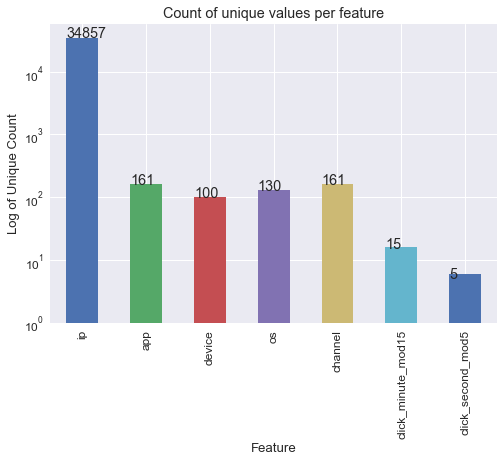

In [16]:
from helper.plotting import plot_df_nunique
plot_df_nunique(train, cat_cols, log_scale=True)

In [17]:
train[cat_cols].nunique().sum()

35429

In [18]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()

In [19]:
%%time
train_onehot = onehot_encoder.fit_transform(train[cat_cols])
test_onehot = onehot_encoder.transform(test[cat_cols])

print(train_onehot.shape)
print(test_onehot.shape)

(100000, 35429)
(18790469, 35429)
CPU times: user 8.74 s, sys: 6.13 s, total: 14.9 s
Wall time: 16.4 s


In [ ]:
from scipy import sparse

In [ ]:
%%time
X_train = sparse.hstack((train[num_cols], train_onehot))
y_train = train[target_col].values

del train
gc.collect()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

In [ ]:
%%time
X_test = sparse.hstack((test[num_cols], test_onehot))

del test
gc.collect()

print('X_test shape:', X_test.shape)

## Save data objects

In [ ]:
display(type(X_train))
display(type(y_train))
display(type(X_test))

In [ ]:
%%time
sparse.save_npz('../scratch/X_train', X_train)
np.save('../scratch/y_train', y_train)
sparse.save_npz('../scratch/X_test', X_test)